<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/doc2vec_viridae_save_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow import keras
from itertools import product
import re

# Read Data

In [32]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/viridae/'
records_df = pd.read_csv(data_path + 'clean.csv')

In [33]:
# replace all '-' with N (stands for any nt)
records_df.seq = records_df.seq.str.replace('-', 'N')
records_df.head()

,id,seq,label
0,NC_036588.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
1,NC_014412.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
2,NC_014413.1,GNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
3,NC_025890.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0
4,NC_023162.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0


In [34]:
def n_gram(x, word_size=3):
  arr_x = [c for c in x]
  words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
  words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
  return words

In [35]:
records_df["ngram"] = records_df.seq.apply(n_gram)
records_df.head()

,id,seq,label,ngram
0,NC_036588.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
1,NC_014412.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
2,NC_014413.1,GNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[GNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
3,NC_025890.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."
4,NC_023162.1,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0,"[NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, NNN, ..."


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain, xtest, ytrain, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((224, 4), (57, 4), (224,), (57,))

In [8]:
word_size = 3
vocab = [''.join(c) for c in product('ATCGN', repeat=word_size)]

In [9]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
xtrain_tagged = xtrain.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["label"]]), axis=1
)
xtest_tagged = xtest.apply(
    lambda r: TaggedDocument(words=r["ngram"], tags=[r["label"]]), axis=1
)

In [ ]:
xtrain_tagged.values[0]

TaggedDocument(words=['NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN', 'NNN'

In [10]:
import multiprocessing
from tqdm import tqdm
import time
tqdm.pandas(desc="progress-bar")

cores = multiprocessing.cpu_count()
cores

2

In [19]:
def getVec(model, tagged_docs, epochs=20):
  sents = tagged_docs.values
  regressors = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
  return np.array(regressors)

def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

def doc2vec_training(embed_size_list=[30,50,80,100], figsize=(10,50), verbose=0):
  num_model = len(embed_size_list)
  fig, axes = plt.subplots(num_model, 2, figsize=figsize)
  counter = 0
  model_list = []
  hist_list = []
  es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
  for embed_size in embed_size_list:
    start = time.time()
    print("training doc2vec for embedding size =", embed_size)
    model_dm = Doc2Vec(dm=1, vector_size=embed_size, negative=5, hs=0, \
                      min_count=2, sample=0, workers=cores)
    if verbose == 1:
      model_dm.build_vocab([x for x in tqdm(xtrain_tagged.values)])
    else:
      model_dm.build_vocab(xtrain_tagged.values)

    for epoch in range(80):
      if verbose == 1:
        model_dm.train([x for x in tqdm(xtrain_tagged.values)], \
              total_examples=len(xtrain_tagged.values), epochs=1)
      else:
        model_dm.train(xtrain_tagged.values, \
              total_examples=len(xtrain_tagged.values), epochs=1)
      model_dm.alpha -= 0.002 
      model_dm.min_alpha = model_dm.alpha
    xtrain_vec = getVec(model_dm, xtrain_tagged)
    xtest_vec = getVec(model_dm, xtest_tagged)
    # save the embedding to csv files
    train_filename = "size" + str(embed_size) + "_train.csv"
    test_filename = "size" + str(embed_size) + "_test.csv"
    np.savetxt(data_path + train_filename, xtrain_vec, delimiter=",")
    np.savetxt(data_path + test_filename, xtest_vec, delimiter=",")
    print("the shape for training vector is", xtrain_vec.shape, \
      "the shape for test vector is", xtest_vec.shape)
    xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
    xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)
    plotVec(axes[counter, 0], xtrain_tsne, ytrain, title="TSNE, training, embedding="+str(embed_size))
    plotVec(axes[counter, 1], xtest_tsne, ytest, title="TSNE, test, embedding="+str(embed_size))
    counter += 1

    print("embedding size =", embed_size)
    model = keras.Sequential([
      keras.layers.Dense(128, activation="relu", input_shape=[embed_size]),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(64, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(32, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(16, activation="relu"), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation="sigmoid")                        
    ])
    model.compile(keras.optimizers.SGD(momentum=0.9), \
          "binary_crossentropy", metrics=["accuracy"])
    hist = model.fit(xtrain_vec, ytrain, \
          epochs=500, callbacks=[es_cb], validation_split=0.2)
    train_loss, train_acc = model.evaluate(xtrain_vec, ytrain)
    test_loss, test_acc = model.evaluate(xtest_vec, ytest)
    print("Evaluation on training set: loss", train_loss, \
          "accuracy", train_acc)
    print("Evaluation on test set: loss", test_loss, \
          "accuracy", test_acc)
    model_list.append(model)
    hist_list.append(hist)
    end = time.time()
    print("running time in ", end - start, "seconds")
    print("\n\n")
  
  return model_list, hist_list

In [20]:
embed_size_list = [50,100,150,200]
num_model = len(embed_size_list)

training doc2vec for embedding size = 50
the shape for training vector is (224, 50) the shape for test vector is (57, 50)
embedding size = 50
Epoch 1/500
6/6 [==============================] - 0s 24ms/step - loss: 0.9864 - accuracy: 0.4804 - val_loss: 0.6835 - val_accuracy: 0.6444
Epoch 2/500
6/6 [==============================] - 0s 5ms/step - loss: 0.7279 - accuracy: 0.4693 - val_loss: 0.6793 - val_accuracy: 0.6222
Epoch 3/500
6/6 [==============================] - 0s 5ms/step - loss: 0.6837 - accuracy: 0.5028 - val_loss: 0.6558 - val_accuracy: 0.5778
Epoch 4/500
6/6 [==============================] - 0s 5ms/step - loss: 0.6647 - accuracy: 0.5363 - val_loss: 0.6176 - val_accuracy: 0.8889
Epoch 5/500
6/6 [==============================] - 0s 5ms/step - loss: 0.6177 - accuracy: 0.6145 - val_loss: 0.5826 - val_accuracy: 0.8444
Epoch 6/500
6/6 [==============================] - 0s 5ms/step - loss: 0.6024 - accuracy: 0.6927 - val_loss: 0.5464 - val_accuracy: 0.8889
Epoch 7/500
6/6 [======

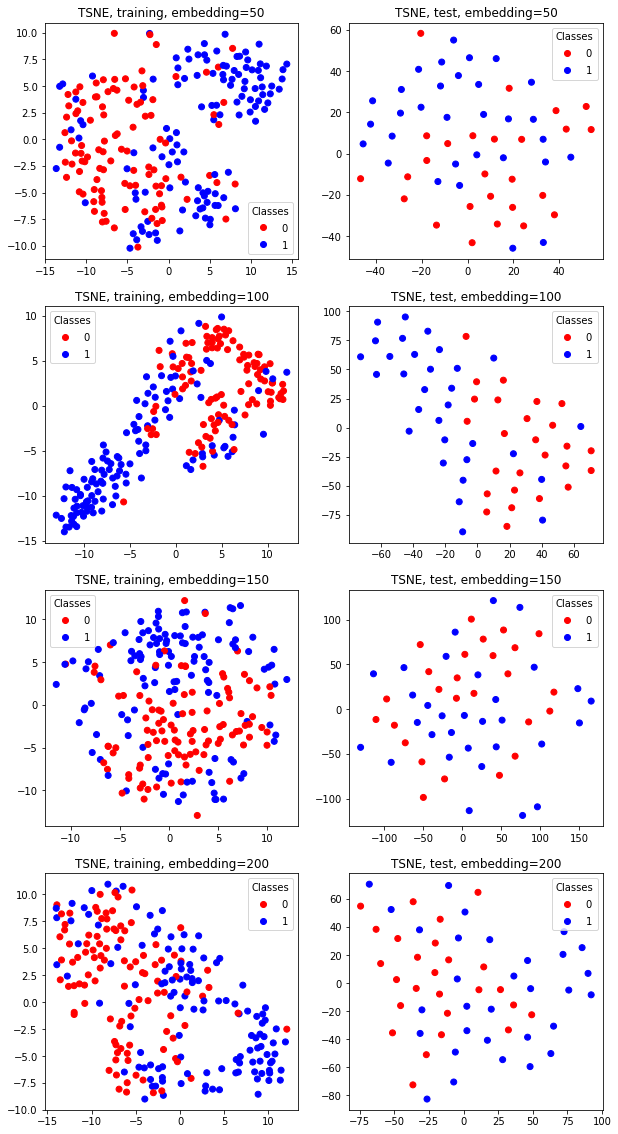

In [23]:
model_list, hist_list = doc2vec_training(embed_size_list, figsize=(10,20))

In [48]:
# training_embeddings = []
# test_embeddings = []
# for s in embed_size_list:
  
#   train_df = pd.read_csv(data_path + train_filename, header=None)
#   test_df = pd.read_csv(data_path + test_filename, header=None)
#   training_embeddings.append(train_df)
#   test_embeddings.append(test_df)

In [43]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [65]:
for i in range(len(embed_size_list)):
  s = embed_size_list[i]
  print("embedding size is {}".format(s))
  train_filename = "size" + str(s) + "_train.csv"
  test_filename = "size" + str(s) + "_test.csv"
  training_vectors = pd.read_csv(data_path + train_filename, header=None)
  test_vectors = pd.read_csv(data_path + test_filename, header=None)
  # evaluation for whole embedding
  train_ch = calinski_harabasz_score(training_vectors, ytrain)
  test_ch = calinski_harabasz_score(test_vectors, ytest)
  train_sil = silhouette_score(training_vectors, ytrain, metric='cosine')
  test_sil = silhouette_score(test_vectors, ytest, metric='cosine')
  # print("Whole embedding, calinski harabasz score for training/test embedding is {}/{}".format(train_ch/224, test_ch/57))
  print("Whole embedding, silhouette score for training/test embedding is {}/{}".format(train_sil, test_sil))

  # TSNE
  xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(training_vectors)
  xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(test_vectors)
  # evaluation for TSNE embedding
  train_ch = calinski_harabasz_score(xtrain_tsne, ytrain)
  test_ch = calinski_harabasz_score(xtest_tsne, ytest)
  train_sil = silhouette_score(xtrain_tsne, ytrain, metric='cosine')
  test_sil = silhouette_score(xtest_tsne, ytest, metric='cosine')
  
  # print("TSNE embedding, calinski harabasz score for training/test embedding is {}/{}".format(train_ch/224, test_ch/57))
  print("TSNE embedding, silhouette score for training/test embedding is {}/{}".format(train_sil, test_sil))


embedding size is 50
Whole embedding, silhouette score for training/test embedding is 0.215291768352952/0.10638766308851637
TSNE embedding, silhouette score for training/test embedding is 0.29420819878578186/0.07687848806381226
embedding size is 100
Whole embedding, silhouette score for training/test embedding is 0.37105176197874185/0.23342197034744316
TSNE embedding, silhouette score for training/test embedding is 0.43185827136039734/0.2556287348270416
embedding size is 150
Whole embedding, silhouette score for training/test embedding is 0.04899377632052342/0.027837879387320116
TSNE embedding, silhouette score for training/test embedding is 0.09799027442932129/0.0021304702386260033
embedding size is 200
Whole embedding, silhouette score for training/test embedding is 0.1317402145445584/0.07340446421600277
TSNE embedding, silhouette score for training/test embedding is 0.2291218489408493/0.06651034206151962


In [29]:
for i in range(len(embed_size_list)):
  s = embed_size_list[i]
  filename = data_path + "size" + str(s) + "_history.csv"
  hist_df = pd.DataFrame(hist_list[i].history) 
  with open(filename, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
# fig, axes = plt.subplots(num_model, 2, figsize=(10, 15))
# for i in range(num_model):
#   hist = hist_list[i]
#   ax1 = axes[i, 0]
#   ax2 = axes[i, 1]

#   ax1.plot(hist.history['loss'], label='training')
#   ax1.plot(hist.history['val_loss'], label='validation')
#   ax1.set_title('model loss, embedding = '+str(embed_size_list[i]))
#   ax1.set_xlabel('epoch')
#   ax1.set_ylabel('loss')
#   ax1.legend(['train', 'test'], loc='upper left')
  
#   ax2.plot(hist.history['accuracy'], label='training')
#   ax2.plot(hist.history['val_accuracy'], label='validation')
#   ax2.set_title('model accuracy, embedding = '+str(embed_size_list[i]))
#   ax2.set_xlabel('epoch')
#   ax2.set_ylabel('accuracy')
#   ax2.legend(['train', 'validation'], loc='upper left')
# fig.tight_layout()

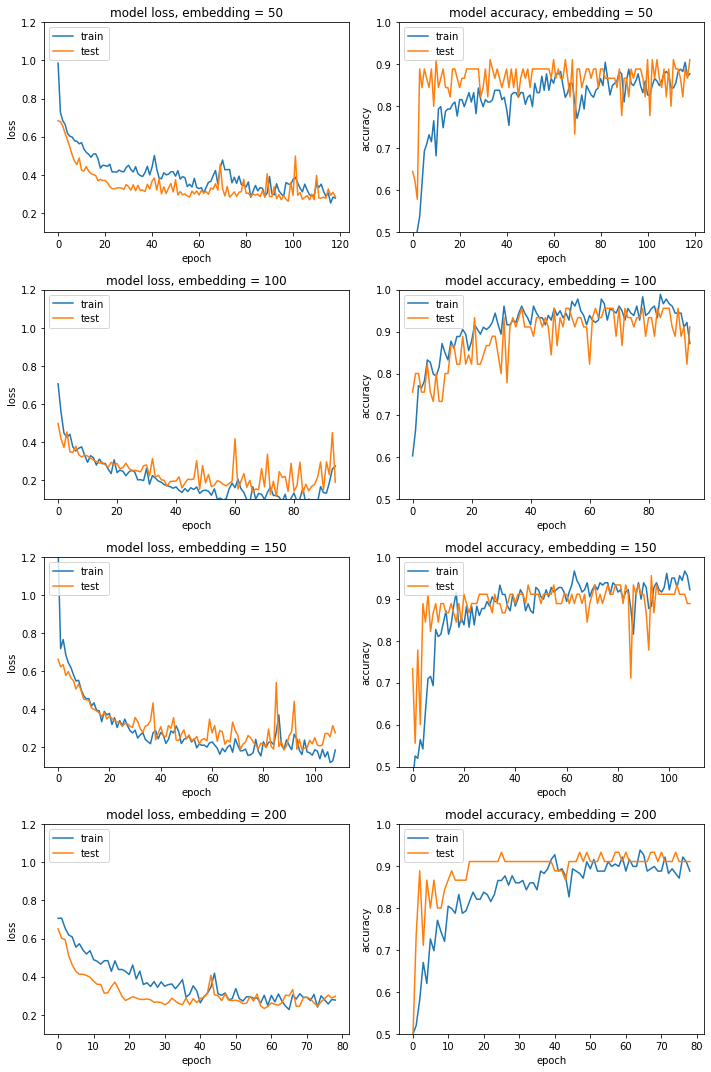

In [62]:
# recovered_hist = []
fig, axes = plt.subplots(num_model, 2, figsize=(10, 15))
for i in range(num_model):
  s = embed_size_list[i]
  filename = data_path + "size" + str(s) + "_history.csv"
  hist_df = pd.read_csv(filename)
  # print(hist.head())
  ax1 = axes[i, 0]
  ax2 = axes[i, 1]

  ax1.plot(hist_df['loss'], label='training')
  ax1.plot(hist_df['val_loss'], label='test')
  ax1.set_ylim(0.1, 1.2)
  ax1.set_title('model loss, embedding = '+str(embed_size_list[i]))
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'test'], loc='upper left')
  
  ax2.plot(hist_df['accuracy'], label='train')
  ax2.plot(hist_df['val_accuracy'], label='test')
  ax2.set_ylim(0.5, 1.0)
  ax2.set_title('model accuracy, embedding = '+str(embed_size_list[i]))
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'test'], loc='upper left')
fig.tight_layout()